## Design and Goal
There are four objects (bed, bench, chair, table). Participants viewed each object 20 times per run.
- Runs 1 & 2 -- reserved to conduct searchlight
- Runs 3 & 4 -- pretest phase 
- Four training runs involving practice drawing two of the trained objects. 
- Runs 5 & 6 -- posttest phase

Our goal is to understand the change in the similarity between representations of trained (vs control) objects in several anatomically-defined ROIs before and after training.

## Approach
#### Unanchored Pre-Post Representational Differentiation
Define 'representation' as cope maps generated upon fitting GLM to each object for each run. Start by building an object x voxel matrix (4xK) for each run and vertically concatenate the two runs in each phase. Using this, compute a correlation matrix. 

Consider M = off-diagonal 4x4 block [:4,4:8] of this matrix; ensure the rows are sorted such that the first two are the Trained, and the last two are the Control objects. Now take the the top-left 2x2 matrix within M and let's call it M-trained. The bottom-right 2x2 = M-control. The diagonal elements of M-trained (A,D depicted below) reflect the representational similarity for the *same* object between runs. The off diagonal elements of M-trained (B,C) reflect the similarity between different objects across runs. Mean of (B,C) - Mean(A,D) = Representational distance between objects in this phase.  
| __ A __ | __ B __ |  
| __ C __ | __ D __ |  
Do the above for the pretest, then for the posttest; the difference between the resulting values is an *unanchored* measure of how differentiated the the object representations have become between the pre and post-training phases:

*Unanchored Differentiation = (Post-Phase Representational Distance) - (Pre-Phase Representational Distance)*

By computing this measure of prepost differentiation again for the control objects and taking the difference between Trained Prepost Differentiation and Control Prepost Differentiation, we attempt to identify the amount of prepost differentiation that occurred specifically as a result of training. 

#### Anchored Pre-Post Representational Differentiation [deprecated]
Another approach to calculating prepost differentiation is to take the mean of the representational distances between different-phase trained object representations (eg the distance between the pre-phase representation of object 1 and the post-phase representation of object 2, and the distance between the pre-phase representation of object 2 and the post-phase representation of object 1) and then subtracting from this mean the representational distance between pre-phase trained object representations (the distance between the pre-phase representations of object 1 and object 2).

In terms of matrix computations, the key difference here from the unanchored measure is beginning with three matrices, and for the first two vertically concatenating corresponding runs of distinct phases (runs 3 and 5, and runs 4 and 6) instead of runs of the same phase. The third matrix is produced the same way the pre-phase object&run-by-voxel matrix is produced for measuring unanchored differentiation. Once representational distance is computed from each of these matrices, anchored prepost representational differentiation is found from the formula:  

*Anchored Differentation = mean((Runs 3&5 Representational Distance), (Runs 4&6 Representational Distance)) - (Pre-Phase Representational Distance)*

As for unanchored differentiation, computing this measure of prepost differentiation again for the control objects and taking the difference between Trained Prepost Differentiation and Control Prepost Differentiation, we attempt to identify the amount of prepost differentiation that occurred specifically as a result of training. 

# Setup

In [1]:
import numpy as np
from numpy import shape
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

In [2]:
## root paths
curr_dir = os.getcwd()
os.path.abspath(os.path.join(curr_dir,'..','..'))

proj_dir = os.path.abspath(os.path.join(curr_dir,'..','..')) ## use relative paths
data_dir = os.path.abspath(os.path.join(curr_dir,'..','..','data')) ## use relative paths 'D:\\data'
results_dir = os.path.join(proj_dir, 'csv')
nb_name = '1_recog_prepost_RSA'

## add helpers to python path
import sys
if os.path.join(proj_dir, 'python') not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'python'))

## module definitions
import analysis_helpers as helpers
core_ROIs = ['V1','V2','LOC','IT','fusiform','parahippo','PRC','ento','hipp']
other_ROIs = ['mOFC','Frontal','Parietal','supraMarginal','Insula','postCentral','preCentral']
ROIs = core_ROIs
all_ROIs = core_ROIs + other_ROIs
core_ROIs_formatted = ["V1", "V2", "LOC", "IT", "FUS", "PHC",  "PRC",  "ENT", "HC"]
other_ROIs_formatted = ['mOFC','Frontal', 'Parietal', 'supra\nmarginal', 'Insula', 'post\nCentral', 'preCentral']
ROIs_formatted = core_ROIs_formatted 
all_ROIs_formatted = core_ROIs_formatted + other_ROIs_formatted
roi_dir = os.path.join(data_dir, 'copes','roi')
cope_dir = os.path.join(data_dir, 'copes','recog','objectGLM')
sub_dirs = sorted(os.listdir(roi_dir))
helpers.roi_dir, helpers.cope_dir = roi_dir, cope_dir

# Similarity analysis

Generate estimate representational differentiation for each subject and each ROI and each condition, outputting a subject-by-roi arrays for each configuration of condition and differentiation measurement approach.

In [ ]:
Tradiffpre, Condiffpre, Tradiffpost, Condiffpost = [], [], [], []

for roi_ind, roi in enumerate(ROIs):
    _Tradiffpre, _Condiffpre, _Tradiffpost, _Condiffpost = [], [], [], []
        
    for s_ind, s in enumerate(sub_dirs):
        print 'Analyzing participant {} | {} of {} in ROI {} | {} of {}'.format(s, s_ind+1, len(sub_dirs), roi, roi_ind+1, len(ROIs))
        clear_output(wait=True)
        trawit_mean_pre, conwit_mean_pre, trabtw_mean_pre, conbtw_mean_pre = \
        helpers.compare_btw_wit_cond_similarity_across_runs(s,'pre',roi)
        trawit_mean_post, conwit_mean_post, trabtw_mean_post, conbtw_mean_post = \
        helpers.compare_btw_wit_cond_similarity_across_runs(s,'post',roi)
        
        trawit_mean_on, conwit_mean_on, trabtw_mean_on, conbtw_mean_on = \
        helpers.compare_btw_wit_cond_similarity_across_runs(s,'35',roi)
        trawit_mean_off, conwit_mean_off, trabtw_mean_off, conbtw_mean_off = \
        helpers.compare_btw_wit_cond_similarity_across_runs(s,'46',roi)
        
        _Tradiffpre.append(trabtw_mean_pre - trawit_mean_pre)
        _Condiffpre.append(conbtw_mean_pre - conwit_mean_pre)
        
        _Tradiffpost.append(trabtw_mean_post - trawit_mean_post)
        _Condiffpost.append(conbtw_mean_post - conwit_mean_post)

    _Tradiffpre,_Condiffpre, _Tradiffpost,_Condiffpost= \
    map(np.array, [_Tradiffpre,_Condiffpre,_Tradiffpost,_Condiffpost])
    
    if len(Tradiffpre)==0:
        Tradiffpre = _Tradiffpre
        Condiffpre = _Condiffpre
        Tradiffpost = _Tradiffpost
        Condiffpost = _Condiffpost
    else:
        Tradiffpre = np.vstack((Tradiffpre,_Tradiffpre))
        Condiffpre = np.vstack((Condiffpre,_Condiffpre))
        Tradiffpost = np.vstack((Tradiffpost,_Tradiffpost))
        Condiffpost = np.vstack((Condiffpost,_Condiffpost))
        
TrainedDiff = Tradiffpost-Tradiffpre
ControlDiff = Condiffpost-Condiffpre

Save out the differentiation measures as a DataFrame inside a csv.

#### longform

In [ ]:
## construct "longform" pandas dataframe with the labels spread out across columns (code could be cleaned up more)

# trained
UTD = pd.DataFrame(TrainedDiff.transpose())
UTD.columns = core_ROIs_formatted
UTD = UTD.assign(condition = pd.Series(np.tile('trained',len(UTD))))

# control
UCD = pd.DataFrame(ControlDiff.transpose())
UCD.columns = core_ROIs_formatted
UCD = UCD.assign(condition = pd.Series(np.tile('control',len(UCD))))

## get trained vs. control differences
UD = UTD[core_ROIs_formatted].sub(UCD[core_ROIs_formatted])
UD = UD.assign(anchoring = pd.Series(np.zeros(len(UD)), dtype=bool)) 
UD = UD.assign(condition = pd.Series(np.tile('difference',len(UD))))

## concatenate into single dataframe
D = pd.concat((UTD,UCD,UD),axis=0,ignore_index=True)

## sanity checks
assert D[D['condition']=='control'].shape[0] == len(UTD)

## melt into long-form dataframe
D = pd.melt(D, 
            id_vars=['condition'], 
            var_name='roi',
            value_vars=core_ROIs_formatted, 
            value_name='prepost_diff')

## add subject column
unique_subs = [i.split('_')[0] for i in sub_dirs]
flat_sub_list = helpers.flatten([unique_subs]*(len(ROIs)*3))
D = D.assign(sub=pd.Series(flat_sub_list))

## save out (note: "anchoring" designation is deprecated)
D.to_csv(os.path.join(results_dir, 'neural_changes_by_surfroi_and_subject_longform.csv'),index=False)

## Learning-related changes in representational distance

Plot prepost representational differentiation for each ROI.  
One plot (4 total) for each possible configuration of these parameters drawn:
- Representational differentiation measure
- Here we plot the relative change in correlation distance between Trained and Control conditions

In [3]:
## load differentation scores back in
D = pd.read_csv(os.path.join(results_dir, 'neural_changes_by_surfroi_and_subject_longform.csv'))

## subset to only differences between trained and control conditions
D = D[D['condition']=='difference']

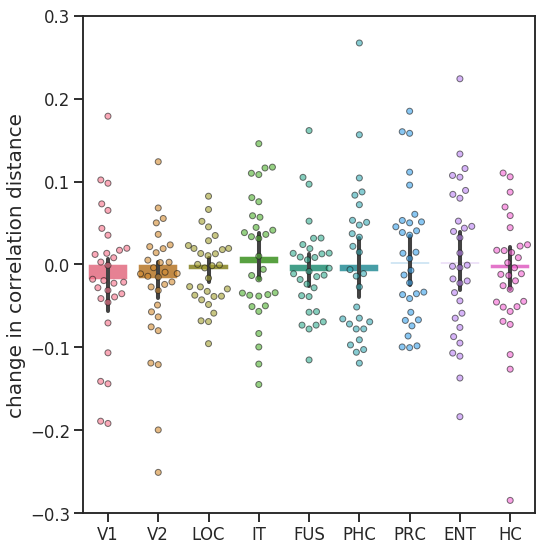

In [5]:
## Effect of Training on Representational DISTANCE:
## Are representational distances between object categories after training compared to our control?
## Change in Representational DISTANCE: YES if Trained reliably more positive than Control

import scipy
def trimmean(x,prop_cut = 0.1):
    return scipy.stats.trim_mean(x,prop_cut)

plt.figure(figsize=(8,8))
sns.set_context('talk')
sns.set_style('ticks')

p = sns.swarmplot(x="roi", 
                    y="prepost_diff", 
                    palette='husl',
                    size=6,
                    linewidth=1,
                    alpha=0.6,
#                     jitter=0.15,
                    edgecolor=(0.1,0.1,0.1),                  
                    data=D)

b = sns.barplot(x='roi',
            y='prepost_diff',
            palette='husl',
            estimator=trimmean,
            ci=95,
            data=D)

plt.ylabel('change in correlation distance',fontsize=20)
plt.xlabel('')
plt.ylim(-0.3,0.3)
plt.tight_layout()
plt.savefig(os.path.join(proj_dir, 'plots', nb_name, 
                         'prepost_differentiation_by_roi_condition.pdf'))